downloading s3://custom-labels-console-us-east-1-67a9361d65/testing-images/gauge-pressure-100.png as gauge-pressure-100.png
downloaded s3://custom-labels-console-us-east-1-67a9361d65/testing-images/gauge-pressure-100.png as gauge-pressure-100.png


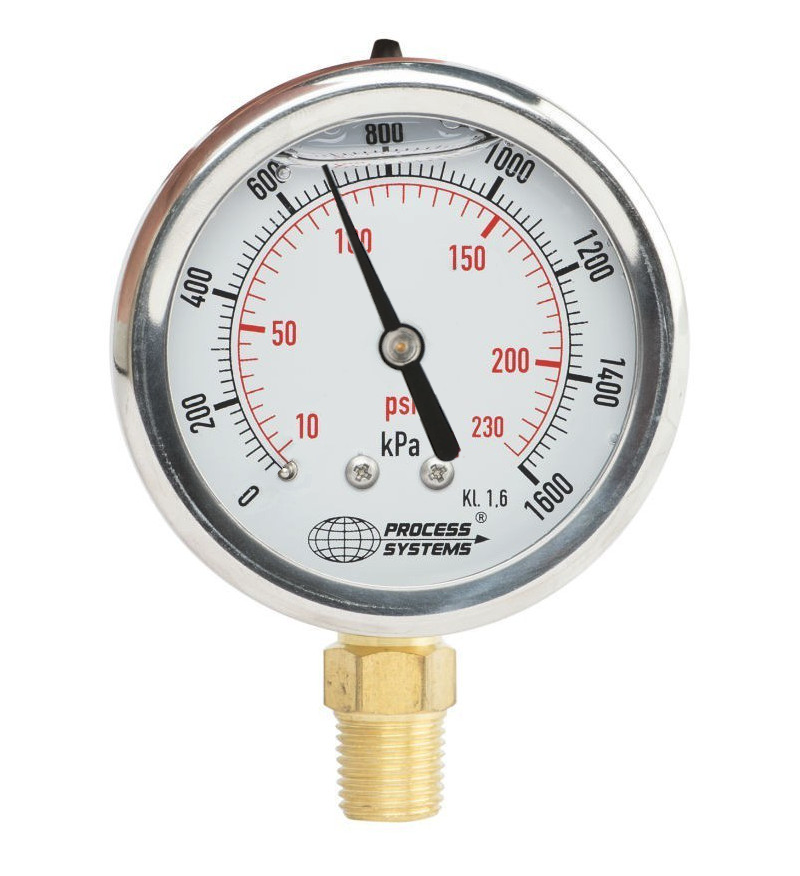

In [108]:
import boto3
import io
from PIL import Image as ImageB, ImageDraw, ExifTags, ImageColor, ImageFont

import cv2
import numpy as np
import time
from pathlib import Path
from IPython.display import Image

# boto3 = boto3.session.Session(profile_name='cv',region_name='us-east-1') # if running locally use a profile
boto3 = boto3.session.Session(region_name='us-east-1') # if running in SageMaker
s3_client = boto3.client('s3')
rekognition_client = boto3.client('rekognition')

# get S3 image details
MY_BUCKET= 'custom-labels-console-us-east-1-67a9361d65'
MY_IMAGE_KEY = 'testing-images/gauge-pressure-100.png'
MY_MODEL_ARN = 'arn:aws:rekognition:us-east-1:158287123688:project/PressureGaugeDetectionv2/version/PressureGaugeDetectionv2.2021-01-13T21.19.23/1610533163713'

# download file from S3
s3Bucket = MY_BUCKET
s3Key = MY_IMAGE_KEY
file_key_prefix = Path(s3Key).stem
file_key_suffix = Path(s3Key).suffix
originalImageFileName = '%s%s'%(file_key_prefix,file_key_suffix)
print('downloading s3://%s/%s as %s'%(s3Bucket, s3Key, originalImageFileName))
s3_client.download_file(s3Bucket, s3Key, originalImageFileName)
print('downloaded s3://%s/%s as %s'%(s3Bucket, s3Key, originalImageFileName))

# display original image
display(Image(filename=originalImageFileName, width=600))

### Call Rekognition API

Call the Rekognition API detect_custom_labels.

In [109]:
# Call DetectCustomLabels

detect_custom_labels_response = rekognition_client.detect_custom_labels(
    Image={'S3Object': {'Bucket': MY_BUCKET, 'Name': MY_IMAGE_KEY}},
    MinConfidence=min_confidence,
    ProjectVersionArn=model
)
print(len(detect_custom_labels_response['CustomLabels']), ' custom labels were detected.')
print('Rekognition full JSON response: ', detect_custom_labels_response)

2  custom labels were detected.
Rekognition full JSON response:  {'CustomLabels': [{'Name': 'GAUGE_PRESSURE_BP_100', 'Confidence': 100.0, 'Geometry': {'BoundingBox': {'Width': 0.7178199887275696, 'Height': 0.7104700207710266, 'Left': 0.1422400027513504, 'Top': 0.038770001381635666}}}, {'Name': 'GAUGE_PRESSURE_BP_100', 'Confidence': 100.0, 'Geometry': {'BoundingBox': {'Width': 0.3949899971485138, 'Height': 0.36164000630378723, 'Left': 0.3362500071525574, 'Top': 0.18780000507831573}}}], 'ResponseMetadata': {'RequestId': '8d0eefcb-b47a-48fd-abec-e53154a312ac', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Fri, 15 Jan 2021 14:10:47 GMT', 'x-amzn-requestid': '8d0eefcb-b47a-48fd-abec-e53154a312ac', 'content-length': '396', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


#### display_image function

The *display_image* function draws box around each label and adds a text label.

Detected custom labels for testing-images/gauge-pressure-100.png with dimensions width=800 and height=876
Label GAUGE_PRESSURE_BP_100
Confidence 100.0
Left: 114
Top: 34
Label Width: 574
Label Height: 622
Label GAUGE_PRESSURE_BP_100
Confidence 100.0
Left: 269
Top: 165
Label Width: 316
Label Height: 317


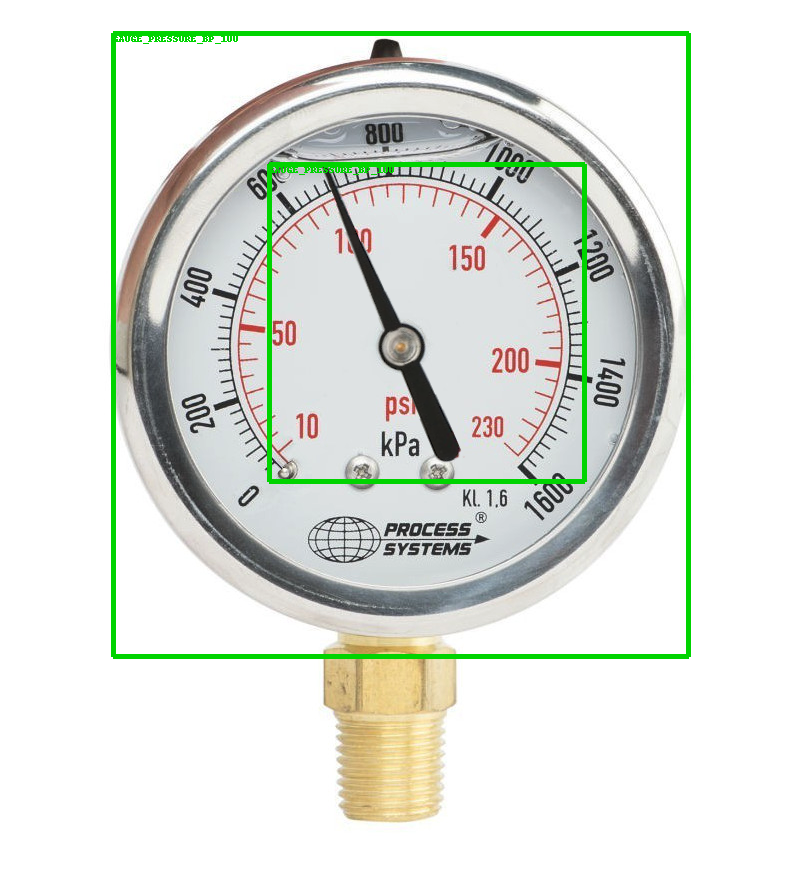

In [110]:
# For object detection use case, uncomment below code to display image.
# display_image(bucket,photo,response)
# return len(response['CustomLabels'])

# Load image from S3 bucket
s3_connection = boto3.resource('s3')

s3_object = s3_connection.Object(MY_BUCKET,MY_IMAGE_KEY)
s3_response = s3_object.get()

stream = io.BytesIO(s3_response['Body'].read())
image=ImageB.open(stream)

imgWidth, imgHeight = image.size
draw = ImageDraw.Draw(image)

# calculate and display bounding boxes for each detected custom label
print('Detected custom labels for ' + MY_IMAGE_KEY +
      ' with dimensions width=' + str(imgWidth) + ' and height=' + str(imgHeight))

for customLabel in detect_custom_labels_response['CustomLabels']:
    print('Label ' + str(customLabel['Name']))
    print('Confidence ' + str(customLabel['Confidence']))
    if 'Geometry' in customLabel:
        box = customLabel['Geometry']['BoundingBox']
        left = imgWidth * box['Left']
        top = imgHeight * box['Top']
        width = imgWidth * box['Width']
        height = imgHeight * box['Height']
        # fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 50)
        # draw.text((left,top), customLabel['Name'], fill='#00d400', font=fnt)
        draw.text((left,top), customLabel['Name'], fill='#00d400')
        print('Left: ' + '{0:.0f}'.format(left))
        print('Top: ' + '{0:.0f}'.format(top))
        print('Label Width: ' + "{0:.0f}".format(width))
        print('Label Height: ' + "{0:.0f}".format(height))
        points = (
            (left,top),
            (left + width, top),
            (left + width, top + height),
            (left , top + height),
            (left, top))
        draw.line(points, fill='#00d400', width=5)

display(image)